# Projet de NLP : Génération de lyrics de rap français (imitation du style de Booba)

Mathieu Naour - Yannis Bouachera

# Préparation

**Installation des bibliothèques et autres dépendances utiles à notre projet**

In [2]:
!pip install lyricsgenius --quiet
!pip install unidecode --quiet
!pip install -U spacy --quiet
!pip install transformers --quiet
!python -m spacy download fr_core_news_md --quiet

     |████████████████████████████████| 59 kB 4.2 MB/s 
     |████████████████████████████████| 235 kB 10.9 MB/s 
     |████████████████████████████████| 6.0 MB 13.6 MB/s 
     |████████████████████████████████| 42 kB 1.7 MB/s 
     |████████████████████████████████| 653 kB 64.7 MB/s 
     |████████████████████████████████| 10.1 MB 52.1 MB/s 
     |████████████████████████████████| 181 kB 77.8 MB/s 
     |████████████████████████████████| 457 kB 65.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
     |████████████████████████████████| 4.0 MB 14.2 MB/s 
     |████████████████████████████████| 895 kB 57.6 MB/s 
     |████████████████████████████████| 6.6 MB 51.2 MB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
     |████████████████████████████████|

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importations des biblios**

In [3]:
import os
import json
import pandas as pd
import numpy as np
import re
import unidecode
import spacy
from lyricsgenius import Genius
import random
import time
import datetime
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config
import matplotlib.pyplot as plt

plt.style.use('seaborn')


wdir = '/content/drive/MyDrive/Projet_NLP'
wdirOH = '/content/drive/MyDrive/Colab Notebooks/NLP/Projet_NLP'

# I - Récupération des données
Nous avons choisi de récupérer l'intégralité des textes de Booba via l'API genius et la bibliothèque python *lyricsgenius* qui permet de facilement utiliser l'API avec Python.

In [ ]:
with open(os.path.join(wdirOH, 'genius_api.txt'), 'r') as file: #getting our API token 
  lines = file.readlines()
  id = lines[0].split(':')[1].strip('\n')
  secret = lines[1].split(':')[1].strip('\n')
  token = lines[2].split(':')[1]

In [ ]:
genius = Genius(token, sleep_time=1) #API access

In [ ]:
artist = genius.search_artist("Booba", sort="title") #scraping Booba's song infos

Searching for songs by Booba...

Song 1: "0.9"
Song 2: "100-8 Zoo"
Song 3: "113"
Song 4: "1.8.7"
Song 5: "2.0"
Song 6: "2PAC"
Song 7: "31"
Song 8: "3G"
Song 9: "45 Scientific"
Song 10: "4G"
Song 11: "5G"
Song 12: "7 Vie Là"
Song 13: "92i Veyron"
Song 14: "92 Izi"
Song 15: "A3"
Song 16: "A4"
Song 17: "Abracadabra"
Song 18: "A.C. Milan"
Song 19: "À la folie"
Song 20: "All Set"
Song 21: "Alter Ego"
Song 22: "Animals"
Song 23: "Arc-en-ciel"
Song 24: "Attila"
Song 25: "Au bout des rêves"
Song 26: "Au bout des rêves (Freestyle)"
Song 27: "Au fond de la classe"
Song 28: "Avant de partir"
Song 29: "Avant de partir (Edit)"
Song 30: "Azerty"
Song 31: "B2OBA"
Song 32: "Baby"
Song 33: "Bad Boy Street"
Song 34: "Bakel City Gang"
Song 35: "Bâtiment C"
Song 36: "Bâtiment C Part II"
Song 37: "BB"
Song 38: "Bellucci"
Song 39: "Billets verts"
Song 40: "Billets violets"
Song 41: "B.O (Freestyle Radio)"
Song 42: "Boîte vocale"
Song 43: "Boîte vocale (Freestyle)"
Song 44: "Bonne journée"
Song 45: "Booba*"


In [ ]:
artist.save_lyrics('lyrics') #saving scrapped data

Wrote lyrics.json.


In [ ]:
with open(os.path.join(wdir,'lyrics.json')) as f: #loading scrapped data
  raw_dict=json.load(f)
  songs = raw_dict['songs'] #only interested about Booba's songs (not his biography, number of followers...)
  df=pd.DataFrame(songs)
  print(songs[0].keys())

dict_keys(['annotation_count', 'api_path', 'artist_names', 'full_title', 'header_image_thumbnail_url', 'header_image_url', 'id', 'lyrics_owner_id', 'lyrics_state', 'path', 'pyongs_count', 'song_art_image_thumbnail_url', 'song_art_image_url', 'stats', 'title', 'title_with_featured', 'url', 'primary_artist', 'apple_music_id', 'apple_music_player_url', 'description', 'embed_content', 'featured_video', 'lyrics_placeholder_reason', 'recording_location', 'release_date', 'release_date_for_display', 'current_user_metadata', 'album', 'custom_performances', 'description_annotation', 'featured_artists', 'lyrics_marked_complete_by', 'lyrics_marked_staff_approved_by', 'media', 'producer_artists', 'song_relationships', 'verified_annotations_by', 'verified_contributors', 'verified_lyrics_by', 'writer_artists', 'artist', 'lyrics'])


In [ ]:
df.head()

,annotation_count,api_path,artist_names,full_title,header_image_thumbnail_url,header_image_url,id,lyrics_owner_id,lyrics_state,path,...,lyrics_marked_staff_approved_by,media,producer_artists,song_relationships,verified_annotations_by,verified_contributors,verified_lyrics_by,writer_artists,artist,lyrics
0,49,/songs/49076,Booba,0.9 by Booba,https://images.genius.com/0a668db07c0bcd135b19...,https://images.genius.com/0a668db07c0bcd135b19...,49076,11644,complete,/Booba-09-lyrics,...,None,[{'native_uri': 'spotify:track:00oY0yXWb4uvpy1...,"[{'api_path': '/artists/44743', 'header_image_...","[{'relationship_type': 'samples', 'type': 'sam...",[],[],[],"[{'api_path': '/artists/1282', 'header_image_u...",Booba,0.9 Lyrics[Intro]\nT'sais quoi ? J'ai d'la 0.9...
1,32,/songs/54715,Booba (Ft. Malekal Morte & Sir Doum's),100-8 Zoo by Booba (Ft. Malekal Morte & Sir Do...,https://images.genius.com/379afec62972255f7b62...,https://images.genius.com/379afec62972255f7b62...,54715,28456,complete,/Booba-100-8-zoo-lyrics,...,None,[{'native_uri': 'spotify:track:3qEtRh1KaqzHnCb...,"[{'api_path': '/artists/655213', 'header_image...","[{'relationship_type': 'samples', 'type': 'sam...",[],[],[],"[{'api_path': '/artists/13258', 'header_image_...",Booba,100-8 Zoo Lyrics[Couplet 1 : Mala]\nJ'écris pa...
2,28,/songs/3338458,Booba (Ft. Damso),113 by Booba (Ft. Damso),https://images.genius.com/438cd49d51f8ada8701c...,https://images.genius.com/438cd49d51f8ada8701c...,3338458,3082514,complete,/Booba-113-lyrics,...,None,"[{'attribution': 'booba official', 'provider':...","[{'api_path': '/artists/184460', 'header_image...","[{'relationship_type': 'samples', 'type': 'sam...",[],[],[],"[{'api_path': '/artists/184460', 'header_image...",Booba,"113 Lyrics[Paroles de ""113"" ft. Damso]\n\n[Int..."
3,35,/songs/94651,Booba (Ft. Rick Ross),1.8.7 by Booba (Ft. Rick Ross),https://images.genius.com/b2fe3a9ec901082ced5a...,https://images.genius.com/b2fe3a9ec901082ced5a...,94651,54235,complete,/Booba-187-lyrics,...,None,[{'native_uri': 'spotify:track:38tpxem3nSSzlhz...,"[{'api_path': '/artists/3029', 'header_image_u...","[{'relationship_type': 'samples', 'type': 'sam...",[],[],[],"[{'api_path': '/artists/1282', 'header_image_u...",Booba,"1.8.7 Lyrics[Paroles de ""1.8.7"" ft. Rick Ross]..."
4,26,/songs/253428,Booba,2.0 by Booba,https://images.genius.com/697af4d75e2024030b44...,https://images.genius.com/697af4d75e2024030b44...,253428,287704,complete,/Booba-20-lyrics,...,None,"[{'provider': 'youtube', 'start': 0, 'type': '...","[{'api_path': '/artists/3029', 'header_image_u...","[{'relationship_type': 'samples', 'type': 'sam...",[],[],[],"[{'api_path': '/artists/1282', 'header_image_u...",Booba,2.0 Lyrics[Couplet 1]\nGeah ! Nouvelle Rolls R...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   annotation_count                 274 non-null    int64  
 1   api_path                         274 non-null    object 
 2   artist_names                     274 non-null    object 
 3   full_title                       274 non-null    object 
 4   header_image_thumbnail_url       274 non-null    object 
 5   header_image_url                 274 non-null    object 
 6   id                               274 non-null    int64  
 7   lyrics_owner_id                  274 non-null    int64  
 8   lyrics_state                     274 non-null    object 
 9   path                             274 non-null    object 
 10  pyongs_count                     209 non-null    float64
 11  song_art_image_thumbnail_url     274 non-null    object 
 12  song_art_image_url    

On voit que les données récupérées comportent bien plus d'informations que nous le souhaitons. On va donc trier les quelques colonnes qui nous intéressent, à savoir le nom de l'artiste (pour repérer les éventuelles chansons avec un ou des featurings), les noms du titre et de l'album ainsi que les paroles.

In [ ]:
cols_to_keep = ['artist_names','album','title','lyrics'] #only useful columns in this project

df = df[cols_to_keep]
df.album=df.album.apply(lambda x : x['name'] if x!=None else None) #only keep album's title
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,artist_names,album,title,lyrics
0,Booba,0.9,0.9,0.9 Lyrics[Intro]\nT'sais quoi ? J'ai d'la 0.9...
1,Booba (Ft. Malekal Morte & Sir Doum's),Temps mort,100-8 Zoo,100-8 Zoo Lyrics[Couplet 1 : Mala]\nJ'écris pa...
2,Booba (Ft. Damso),Trône,113,"113 Lyrics[Paroles de ""113"" ft. Damso]\n\n[Int..."
3,Booba (Ft. Rick Ross),Futur,1.8.7,"1.8.7 Lyrics[Paroles de ""1.8.7"" ft. Rick Ross]..."
4,Booba,Futur 2.0,2.0,2.0 Lyrics[Couplet 1]\nGeah ! Nouvelle Rolls R...


In [ ]:
df.loc[df.artist_names != 'Booba'] # feats (we may need to delete other rappers' lyrics)

,artist_names,album,title,lyrics
1,Booba (Ft. Malekal Morte & Sir Doum's),Temps mort,100-8 Zoo,100-8 Zoo Lyrics[Couplet 1 : Mala]\nJ'écris pa...
2,Booba (Ft. Damso),Trône,113,"113 Lyrics[Paroles de ""113"" ft. Damso]\n\n[Int..."
3,Booba (Ft. Rick Ross),Futur,1.8.7,"1.8.7 Lyrics[Paroles de ""1.8.7"" ft. Rick Ross]..."
6,Booba (Ft. Gato),ULTRA,31,"31 Lyrics[Paroles de ""31"" ft. Gato]\n\n[Intro ..."
8,Booba (Ft. Dosseh),Lunatic,45 Scientific,45 Scientific Lyrics[Intro : Booba]\nTant pis...
...,...,...,...,...
263,Booba (Ft. Twinsmatic),Nero Nemesis,U2K,"U2K Lyrics[Paroles de ""U2K"" ft. Twinsmatic]\n\..."
267,Booba (Ft. Benash),Nero Nemesis,Validée,Validée Lyrics[Intro : Booba]\nJe l'avais vali...
269,Booba (Ft. Dala (FRA)),ULTRA,Vue sur la mer,"Vue sur la mer Lyrics[Paroles de ""Vue sur la m..."
270,Booba (Ft. Maes),ULTRA,VVV,"VVV Lyrics[Paroles de ""VVV"" ft. Maes]\n\n[Intr..."


In [ ]:
df.to_csv('df_raw.csv',index=False) #save our raw dataframe

# II - Preprocessing

In [ ]:
df = pd.read_csv(os.path.join(wdir,'df_raw.csv'),index_col=[0])

In [ ]:
df

,artist_names,album,title,lyrics
0,Booba,0.9,0.9,0.9 Lyrics[Intro]\nT'sais quoi ? J'ai d'la 0.9...
1,Booba (Ft. Malekal Morte & Sir Doum's),Temps mort,100-8 Zoo,100-8 Zoo Lyrics[Couplet 1 : Mala]\nJ'écris pa...
2,Booba (Ft. Damso),Trône,113,"113 Lyrics[Paroles de ""113"" ft. Damso]\n\n[Int..."
3,Booba (Ft. Rick Ross),Futur,1.8.7,"1.8.7 Lyrics[Paroles de ""1.8.7"" ft. Rick Ross]..."
4,Booba,Futur 2.0,2.0,2.0 Lyrics[Couplet 1]\nGeah ! Nouvelle Rolls R...
...,...,...,...,...
269,Booba (Ft. Dala (FRA)),ULTRA,Vue sur la mer,"Vue sur la mer Lyrics[Paroles de ""Vue sur la m..."
270,Booba (Ft. Maes),ULTRA,VVV,"VVV Lyrics[Paroles de ""VVV"" ft. Maes]\n\n[Intr..."
271,Booba,Nero Nemesis,Walabok,"Walabok Lyrics[Paroles de ""Walabok""]\n\n[Intro..."
272,Booba,Futur,Wesh Morray,"Wesh Morray Lyrics[Paroles de ""Wesh Morray""]\n..."


## Data cleaning
Le nom des artistes, albums, chansons sont propres, cependant les paroles des chansons ont besoin de subir différentes étapes de nettoyage ( beaucoup de balises "intro"  "couplet", annotations...)

On va écrire les fonctions une à une en se servant d'une chanson comme exemple, puis les agréger toutes dans une fonction maitre pour la suite

In [ ]:
lyrics_ex = df.iloc[12,3]
lyrics_ex[:100]

'92i Veyron Lyrics[Paroles de "92i Veyron"]\n\n[Intro]\nPersonne, personne\nPersonne, personne\n\n[Couplet '

On commence par retirer la balise du début qui contient toujours le nom du morceau suivi de "Lyrics"

In [ ]:
titre = df.iloc[12,2]
lyrics_ex = lyrics_ex.split('%s Lyrics' % titre)[1]
lyrics_ex[:100]

'[Paroles de "92i Veyron"]\n\n[Intro]\nPersonne, personne\nPersonne, personne\n\n[Couplet 1]\nNouveau riche,'

On supprime aussi tout le texte contenu dans l'intro ou l'outro

In [ ]:
lyrics_ex = re.sub("\[Intro\](.|\n)*?[\]\)]", "", lyrics_ex)
lyrics_ex = re.sub("\[Outro\](.|\n)*Embed", "", lyrics_ex) # Ttes les chansons ont l'air de finir par 'Embed'
lyrics_ex[:100]

'[Paroles de "92i Veyron"]\n\n\nNouveau riche, ma Lamborghini a pris quelques dos-d\'âne\nJ\'fais ni la que'

On retire tous les éléments entre crochets (balises) ou entre parenthèses (backing).

*   Élément de liste
*   Élément de liste



In [ ]:
lyrics_ex = re.sub("[\(\[].*?[\)\]]\n", "", lyrics_ex)
lyrics_ex[:100]

"@$Nouveau riche, ma Lamborghini a pris quelques dos-d'âne$J'fais ni la queue au Ritz, ni au McDonald"

On retire les retours à la ligne \n pour les remplacer par un point.

In [ ]:
lyrics_ex = re.sub("(\n)+", ".", lyrics_ex)
lyrics_ex

'@$Nouveau riche, ma Lamborghini a pris quelques dos-d\'âne$J\'fais ni la queue au Ritz, ni au McDonald\'s$Si c\'est eux qui ont raison, je n\'suis pas raisonnable$La rafale dans ton salon s\'ra sûrement désagréable$Nouveau riche, ma Lamborghini a pris quelques dos-d\'âne$J\'fais ni la queue au Ritz, ni au McDonald\'s$Si c\'est eux qui ont raison, je n\'suis pas raisonnable$La rafale dans ton salon s\'ra sûrement désagréable$@On trinque à nos balafres, à nos crochets tous les soirs$"Noir c\'est noir", ont-ils dit, y a donc vraiment plus d\'espoir$Les vainqueurs l\'écrivent, les vaincus racontent l\'histoire$Les vainqueurs l\'écrivent, les vaincus racontent l\'histoire$Personne dans le monde ne marche du même pas$Leurs règles ont toutes une tombe, c\'est ça qu\'ils n\'comprennent pas$Des allers-retours en prison, certains n\'en reviennent pas$J\'ai une kalash et des mouftons, tous sous le même toit$Toujours d\'humeur à les lever, que l\'avenir suce mon troisième doigt$Non, moi je n\'t\'

On agrège toutes ces étapes dans une fonction qui appliquera le preprocessing sur la totalité du dataframe :

In [ ]:
def clean_lyrics(df_raw):
  """
  Prend en input le dataframe avec 4 colonnes (artiste, album, titre, paroles) et renvoie un dataframe avec les 4 mêmes
  colonnes et les paroles nettoyées en suivant les étapes décrites au dessus. 
  """
  df_clean = df_raw.copy()
  for index in range(len(df_clean)):
    df_clean.loc[index, 'lyrics'] = df_clean.loc[index, 'lyrics'].split('%s Lyrics' % df_clean.loc[index, 'title'])[1]

  df_clean['lyrics'] = df_clean['lyrics'].apply(lambda lyrics: re.sub("\[Intro\](.|\n)*?[\]\)]", "", lyrics))
  df_clean['lyrics'] = df_clean['lyrics'].apply(lambda lyrics: re.sub("\[Outro\](.|\n)*Embed", "", lyrics))
  df_clean['lyrics'] = df_clean['lyrics'].apply(lambda lyrics: re.sub("[\(\[].*?[\)\]]\n", "", lyrics))
  df_clean['lyrics'] = df_clean['lyrics'].apply(lambda lyrics: re.sub("(\n)+", ".", lyrics))
  df_clean['lyrics'] = df_clean['lyrics'].apply(lambda lyrics: lyrics.strip('.')+'.')

  

  return df_clean

In [ ]:
df_clean = clean_lyrics(df)
del df

## Preparation des données via Spacy

In [ ]:
nlp = spacy.load('fr_core_news_md')

In [ ]:
lyrics_ex = df_clean.iloc[12,3]
lyrics_ex

'Nouveau riche, ma Lamborghini a pris quelques dos-d\'âne.J\'fais ni la queue au Ritz, ni au McDonald\'s.Si c\'est eux qui ont raison, je n\'suis pas raisonnable.La rafale dans ton salon s\'ra sûrement désagréable.Nouveau riche, ma Lamborghini a pris quelques dos-d\'âne.J\'fais ni la queue au Ritz, ni au McDonald\'s.Si c\'est eux qui ont raison, je n\'suis pas raisonnable.La rafale dans ton salon s\'ra sûrement désagréable.On trinque à nos balafres, à nos crochets tous les soirs."Noir c\'est noir", ont-ils dit, y a donc vraiment plus d\'espoir.Les vainqueurs l\'écrivent, les vaincus racontent l\'histoire.Les vainqueurs l\'écrivent, les vaincus racontent l\'histoire.Personne dans le monde ne marche du même pas.Leurs règles ont toutes une tombe, c\'est ça qu\'ils n\'comprennent pas.Des allers-retours en prison, certains n\'en reviennent pas.J\'ai une kalash et des mouftons, tous sous le même toit.Toujours d\'humeur à les lever, que l\'avenir suce mon troisième doigt.Non, moi je n\'t\'aim

On va d'abord mettre un place un tokenizer légèrement modifié afin de l'adapter aux particularités des textes utilisés.
Notamment, on ne veut pas séparer en deux mots distincs les mots contenant un tiret : les paroles de Booba contiennent beaucoup de verlan.

*On veut également prendre en compte la structure particulière du texte : plusieurs couples (couplet ici ~ couplet, refrain, pont...) chacun comportant plusieurs lignes, avec une ligne = une punchline.*

In [ ]:
from spacy.tokenizer import Tokenizer
from spacy.util import compile_infix_regex


def custom_tokenizer(nlp):
    inf = list(nlp.Defaults.infixes)               # Default infixes
    inf.remove(r"(?<=[0-9])[+\-\*^](?=[0-9-])")    # Remove the generic op between numbers or between a number and a -
    inf = tuple(inf)                               # Convert inf to tuple
    infixes = inf + tuple([r"(?<=[0-9])[+*^](?=[0-9-])", r"(?<=[0-9])-(?=-)"])  # Add the removed rule after subtracting (?<=[0-9])-(?=[0-9]) pattern
    infixes = [x for x in infixes if '-|–|—|--|---|——|~' not in x] # Remove - between letters rule
    infix_re = compile_infix_regex(infixes)

    return Tokenizer(nlp.vocab, prefix_search=nlp.tokenizer.prefix_search,
                                suffix_search=nlp.tokenizer.suffix_search,
                                infix_finditer=infix_re.finditer,
                                token_match=nlp.tokenizer.token_match,
                                rules=nlp.Defaults.tokenizer_exceptions)

nlp.tokenizer = custom_tokenizer(nlp)

In [ ]:
doc = nlp(df_clean.lyrics[6])

for sentence in doc.sents:
  print(sentence.text)
  print([tok.text.strip('-') for tok in sentence if not tok.is_punct])
  print('\n')

Glock .17
['Glock', '.17']


, j'en prends soin.
["j'", 'en', 'prends', 'soin']


Glock .17
['Glock', '.17']


, j'en prends soin.
["j'", 'en', 'prends', 'soin']


Ça s'voit qu't'es une grosse putain, que t'es clitoridien.
['Ça', "s'", 'voit', "qu'", "t'", 'es', 'une', 'grosse', 'putain', 'que', "t'", 'es', 'clitoridien']


Toujours sur mon 31, le sale, mon quotidien.
['Toujours', 'sur', 'mon', '31', 'le', 'sale', 'mon', 'quotidien']


J'ai matché avec tchoin, tchoin, tchoin, j'ai swipé sur la gauche, eh.
["J'", 'ai', 'matché', 'avec', 'tchoin', 'tchoin', 'tchoin', "j'", 'ai', 'swipé', 'sur', 'la', 'gauche', 'eh']


Glock .17
['Glock', '.17']


, j'en prends soin, j'ai ridé toute la noche.
["j'", 'en', 'prends', 'soin', "j'", 'ai', 'ridé', 'toute', 'la', 'noche']


Combien d'bouteilles à la mer échouées dans des eaux mortes ?
['Combien', "d'", 'bouteilles', 'à', 'la', 'mer', 'échouées', 'dans', 'des', 'eaux', 'mortes']


.Ça va, ça va pas, pas du genre à frapper aux portes Attiré par l

In [ ]:
for sentence in doc.sents:
  print(sentence.text)
  print([tok.text for tok in sentence if not (tok.is_punct or tok.is_stop)]) #removing stop words
  print('\n')

Glock .17
['Glock', '.17']


, j'en prends soin.
['prends', 'soin']


Glock .17
['Glock', '.17']


, j'en prends soin.
['prends', 'soin']


Ça s'voit qu't'es une grosse putain, que t'es clitoridien.
['voit', 'grosse', 'putain', 'clitoridien']


Toujours sur mon 31, le sale, mon quotidien.
['31', 'sale', 'quotidien']


J'ai matché avec tchoin, tchoin, tchoin, j'ai swipé sur la gauche, eh.
['matché', 'tchoin', 'tchoin', 'tchoin', 'swipé', 'gauche']


Glock .17
['Glock', '.17']


, j'en prends soin, j'ai ridé toute la noche.
['prends', 'soin', 'ridé', 'noche']


Combien d'bouteilles à la mer échouées dans des eaux mortes ?
['bouteilles', 'mer', 'échouées', 'eaux', 'mortes']


.Ça va, ça va pas, pas du genre à frapper aux portes Attiré par le vide si je restais au bord.
['.Ça', 'genre', 'frapper', 'portes', 'Attiré', 'vide', 'restais', 'bord']


Ils m'ont attrapé en Afrique, m'ont forcé à marcher au Nord.
['attrapé', 'Afrique', 'forcé', 'marcher', 'Nord']


C'navire n'est pas sûr de rentre

On agrège tout ça dans une fonction pour tout le dataframe, puis on sauvegarde le dataframe.

In [ ]:
def split_tokenize(df):

  def split_tok_lyrics(song_lyrics):
    doc = nlp(song_lyrics)
    results = []
    for sentence in doc.sents :
      tokenized_sent = [token.text.strip('-') for token in sentence if not token.is_punct]
      if tokenized_sent :
        results.append(tokenized_sent)

    return results

  df_tokenized = df.copy()
  df_tokenized['lyrics'] = df_tokenized['lyrics'].apply(split_tok_lyrics)

  return df_tokenized

In [ ]:
df_tok = split_tokenize(df_clean)

df_tok.head()

,artist_names,album,title,lyrics
0,Booba,0.9,0.9,"[[9, décembre, j', ai, les, mains, froides], [..."
1,Booba (Ft. Malekal Morte & Sir Doum's),Temps mort,100-8 Zoo,"[[J', écris, pas, d', douceurs, p', t', être, ..."
2,Booba (Ft. Damso),Trône,113,"[[On, a, l', klawi, juice], [Oh, oh, oh], [Y',..."
3,Booba (Ft. Rick Ross),Futur,1.8.7,"[[It', s, global], [This, worldwide, right, he..."
4,Booba,Futur 2.0,2.0,"[[Geah], [Nouvelle, Rolls, Royce, sur, du, 22,..."


In [ ]:
df_tok.to_csv(os.path.join(wdir, 'df_tokenized.csv'))

# III - Etude de la base de données

## III - A. Word clouds (mots les plus fréquents)

Pour les nuages de mot, on a besoin de versions légèrement modifiées de la fonction précédente : on retire tout d'abord les stopwords du dataset pour ne visualiser que les mots "intéressants" dans notre nuage.

On va également par la suite constituer des nuages de mots ne contenant que les adjectifs, les noms, les verbes...

In [ ]:
def split_tokenize_words(df):

  def split_tok_lyrics(song_lyrics):
    doc = nlp(song_lyrics)
    results = []
    for sentence in doc.sents :
      tokenized_sent = [token.text.strip('-') for token in sentence if not (token.is_punct or token.is_stop or len(token.text) < 3)]
      if tokenized_sent :
        results.append(tokenized_sent)

    return results

  df_wordclouds = df.copy()
  df_wordclouds['lyrics'] = df_wordclouds['lyrics'].apply(split_tok_lyrics)

  return df_wordclouds

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def draw_wordcloud(df):
  word_list = [word for song in df.lyrics for sentence in song for word in sentence]

  cloud = WordCloud(background_color = "white", colormap = 'Dark2', 
                    max_font_size=150, width = 1000, height = 600, random_state = 42).generate(" ".join(word_list))
  
  plt.figure(figsize=(15,15))
  plt.imshow(cloud)
  plt.axis('off')

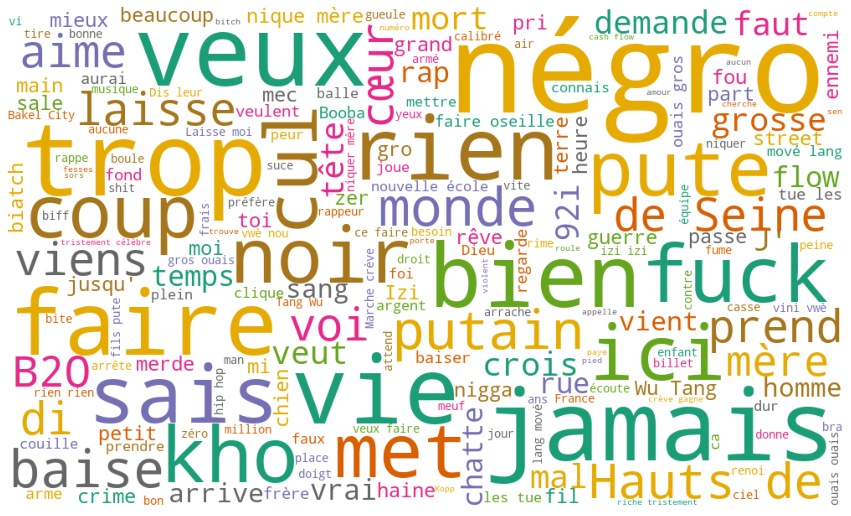

In [ ]:
draw_wordcloud(split_tokenize_words(df_clean))

**Nuage des adjectifs**

In [ ]:
def split_tokenize_adj(df):

  def split_tok_lyrics(song_lyrics):
    doc = nlp(song_lyrics)
    results = []
    for sentence in doc.sents :
      tokenized_sent = [token.text.strip('-') for token in sentence if token.pos_=='ADJ' and (not token.is_stop)]
      if tokenized_sent :
        results.append(tokenized_sent)

    return results

  df_adj = df.copy()
  df_adj['lyrics'] = df_adj['lyrics'].apply(split_tok_lyrics)

  return df_adj

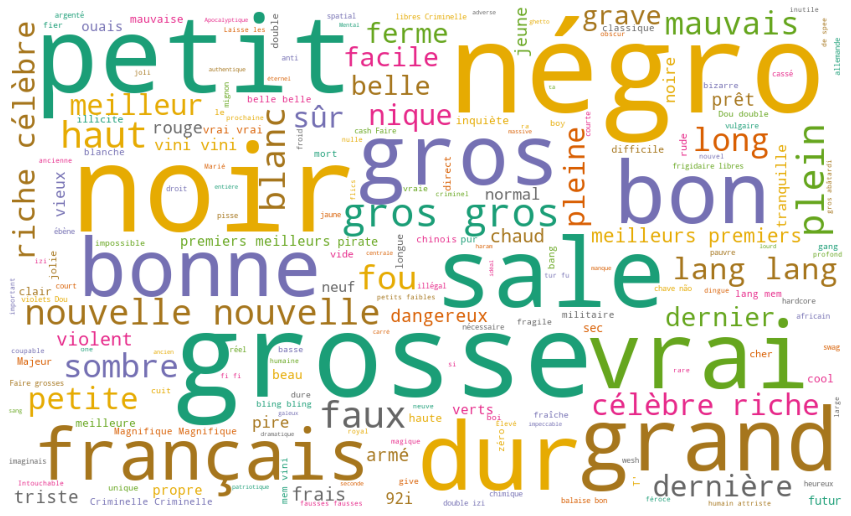

In [ ]:
draw_wordcloud(split_tokenize_adj(df_clean))

**Nuage des noms**

In [ ]:
def split_tokenize_nouns(df):

  def split_tok_lyrics(song_lyrics):
    doc = nlp(song_lyrics)
    results = []
    for sentence in doc.sents :
      tokenized_sent = [token.text for token in sentence if token.pos_=='NOUN' and (not token.is_stop)]
      if tokenized_sent :
        results.append(tokenized_sent)

    return results

  df_nouns = df.copy()
  df_nouns['lyrics'] = df_nouns['lyrics'].apply(split_tok_lyrics)

  return df_nouns

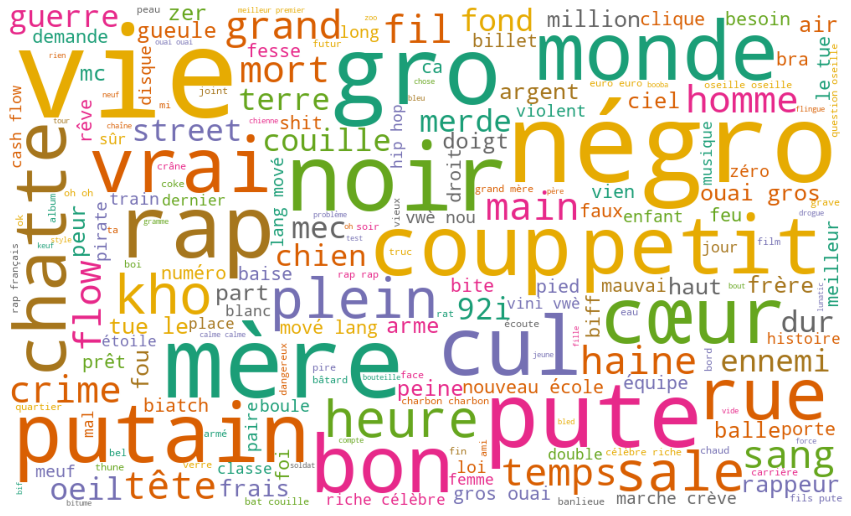

In [ ]:
draw_wordcloud(split_tokenize_nouns(df_clean))

**Nuage noms & adjectifs**

In [ ]:
def split_tokenize_adj_nouns(df):

  def split_tok_lyrics(song_lyrics):
    doc = nlp(song_lyrics)
    results = []
    for sentence in doc.sents :
      tokenized_sent = [token.lemma_ for token in sentence if (token.pos_=='NOUN' or token.pos_ == 'ADJ') and (not token.is_stop)]
      if tokenized_sent :
        results.append(tokenized_sent)

    return results

  df_adj_nn = df.copy()
  df_adj_nn['lyrics'] = df_adj_nn['lyrics'].apply(split_tok_lyrics)

  return df_adj_nn

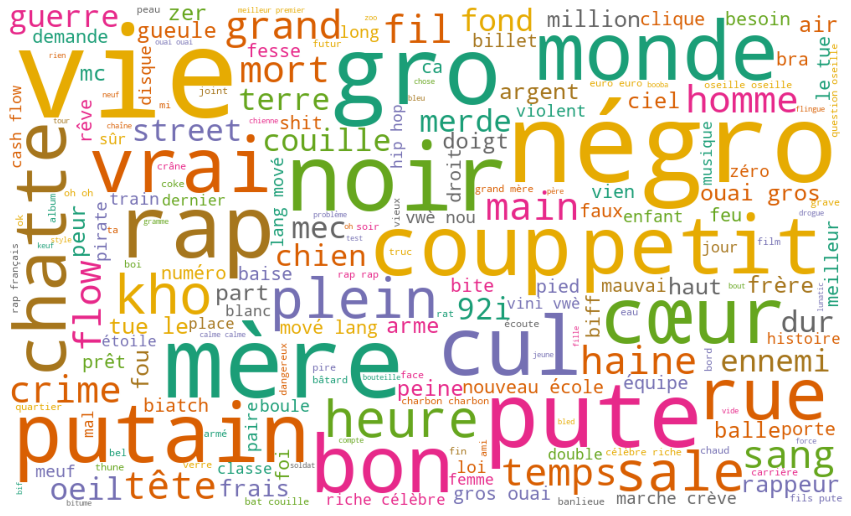

In [ ]:
draw_wordcloud(split_tokenize_adj_nouns(df_clean))

**Nuage sans verbe**

In [ ]:
def split_tokenize_verbs(df):

  def split_tok_lyrics(song_lyrics):
    doc = nlp(song_lyrics)
    results = []
    for sentence in doc.sents :
      tokenized_sent = [token.lemma_ for token in sentence if not((token.pos_=='VERB') or token.is_punct or token.is_stop or len(token.text)<3)]
      if tokenized_sent :
        results.append(tokenized_sent)

    return results

  df_verbs = df.copy()
  df_verbs['lyrics'] = df_verbs['lyrics'].apply(split_tok_lyrics)

  return df_verbs

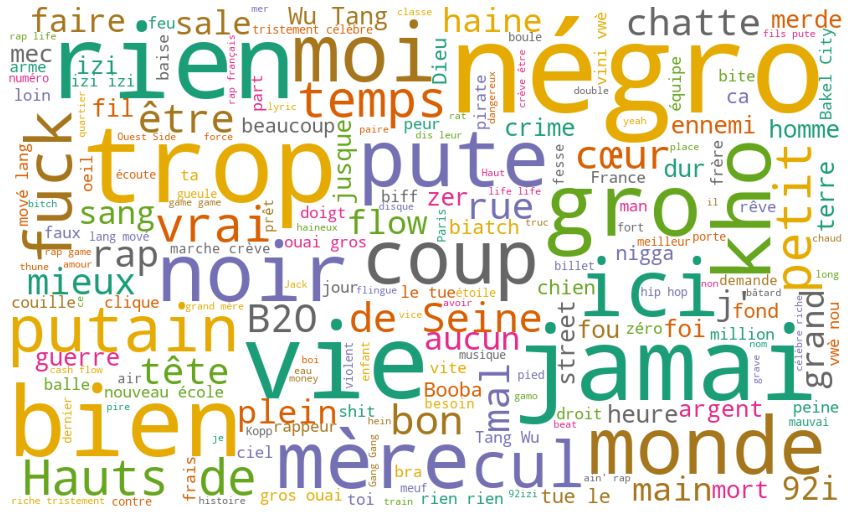

In [ ]:
draw_wordcloud(split_tokenize_verbs(df_clean))

## III - B. Statistiques descriptives

**Nombre moyens de mots dans une chanson et distribution des mots**

In [ ]:
def wordcount(df):
  df_count = split_tokenize_words(df)

  global_count = {}

  def count_words(song_lyrics):
    flattened_lyrics = []
    for words in song_lyrics:
      flattened_lyrics.extend(words)

    count_dict = {}
    word_sum = len(flattened_lyrics)
    for word in flattened_lyrics :
      count_dict[word] = count_dict.setdefault(word, 0) + 1
      global_count[word] = global_count.setdefault(word, 0) + 1


    return [count_dict, word_sum]

  df_count['temp_col'] = df_count['lyrics'].apply(count_words)

  df_count['word_count'] = df_count['temp_col'].apply(lambda x: x[0])
  df_count['total_words'] = df_count['temp_col'].apply(lambda x: x[1])
  df_count.drop('temp_col', axis = 1)


  return df_count, pd.DataFrame(global_count, index = ['word_count']).transpose().reset_index().sort_values(by = 'word_count', ascending = False)

In [ ]:
df_count, df_global = wordcount(df_clean)

<BarContainer object of 274 artists>

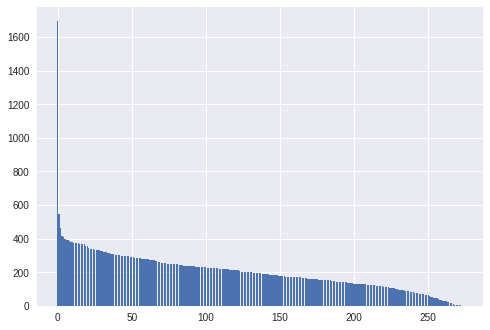

In [ ]:
plt.bar(x = range(len(df_count)), height = df_count.sort_values(by = 'total_words', ascending = False).total_words)

On voit que l'immense majorité des chansons contiennent entre 400 et 100 mots.


On s'intéresse aux outliers :

In [ ]:
df_count.sort_values(by = 'total_words', ascending = False).tail(23)

,artist_names,album,title,lyrics,temp_col,word_count,total_words
238,Booba,NaN,Sport Billy*,"[[Yacine, smoke, the, track], [Rap, apocalypti...","[{'Yacine': 1, 'smoke': 1, 'the': 1, 'track': ...","{'Yacine': 1, 'smoke': 1, 'the': 1, 'track': 1...",58
95,Booba,Futur,G5 (Intro),"[[Massif, âme, destruction, massive], [Machine...","[{'Massif': 1, 'âme': 1, 'destruction': 1, 'ma...","{'Massif': 1, 'âme': 1, 'destruction': 1, 'mas...",53
198,Booba (Ft. Mala & Nessbeal),Autopsie Vol. 1,Outro (A1),"[[Animateur, radio, Euh, dernier, mot, quelqu'...","[{'Animateur': 3, 'radio': 3, 'Euh': 1, 'derni...","{'Animateur': 3, 'radio': 3, 'Euh': 1, 'dernie...",50
117,Booba,Bomb Tape Volume VII - Époque Hip Hop V2,Inédit Unique,"[[viens, Hauts, Seine, obscène, style, comport...","[{'viens': 1, 'Hauts': 1, 'Seine': 1, 'obscène...","{'viens': 1, 'Hauts': 1, 'Seine': 1, 'obscène'...",48
134,Booba,NaN,Je sais (Freestyle Rihanna),"[[comptoir, titty, bar, partout, Trinidad], [a...","[{'comptoir': 1, 'titty': 1, 'bar': 1, 'partou...","{'comptoir': 1, 'titty': 1, 'bar': 1, 'partout...",48
244,Booba,NaN,Tatouages de Booba,"[[Visage.•], [7Cou.•, 45.•], [Poing, levéTorse...","[{'Visage.•': 1, '7Cou.•': 1, '45.•': 1, 'Poin...","{'Visage.•': 1, '7Cou.•': 1, '45.•': 1, 'Poing...",46
200,Booba,NaN,Pablo,"[[voient, faits, gestes, vole, aigle, horizon,...","[{'voient': 1, 'faits': 1, 'gestes': 1, 'vole'...","{'voient': 1, 'faits': 1, 'gestes': 1, 'vole':...",41
195,Booba,Autopsie Vol. 2,Ouais ouais (Freestyle Planet Rap),"[[vie, buts, attendre, passe, décisive], [Menn...","[{'vie': 1, 'buts': 1, 'attendre': 1, 'passe':...","{'vie': 1, 'buts': 1, 'attendre': 1, 'passe': ...",35
257,Booba,NaN,Tout c’que j’ai appris*,"[[Paroles, venant, extrait], [appris], [Femmes...","[{'Paroles': 1, 'venant': 1, 'extrait': 1, 'ap...","{'Paroles': 1, 'venant': 1, 'extrait': 1, 'app...",33
167,Booba,Sortis de l’ombre,Lunintro,"[[Sortis, ombre, territoire, jusqu', inconnu, ...","[{'Sortis': 1, 'ombre': 1, 'territoire': 1, 'j...","{'Sortis': 1, 'ombre': 1, 'territoire': 1, 'ju...",29


On voit que la plupart de ces entrées ne sont en réalité pas des chansons mais des pages d'informations, des extraits de chansons complètes ou des artefacts de Genius. 
On retrouve quelques intro/outro courtes à partir d'un certain moment, on va donc omettre les 20 dernières chansons de notre base d'entrainement.

In [ ]:
titles_to_drop = df_count.sort_values(by = 'total_words').head(20).title

In [ ]:
df_clean_dropped = df_clean[~df_clean.title.isin(titles_to_drop)].reset_index()
df_tok_dropped = df_tok[~df_tok.title.isin(titles_to_drop)].reset_index()

df_clean_dropped.to_csv(os.path.join(wdir, 'df_clean_dropped.csv'))
df_tok_dropped.to_csv(os.path.join(wdir, 'df_tokenized_dropped.csv'))

Par curiosité, on regarde la distribution de l'apparition des mots dans les textes de Booba (loi de Zipf).

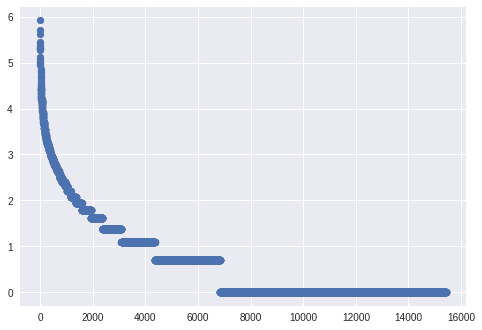

In [ ]:
plt.scatter(x = range(len(df_global)), y = np.log(df_global['word_count']))

In [ ]:
df_global.head()

,index,word_count
245,faire,372
476,veux,303
29,vie,278
44,rien,234
469,bien,216


**Part of Speech**

On va analyser combien d'adjectifs, de noms, de verbes... sont contenus en moyenne dans une phrase.

In [ ]:
def pos_analysis(df):

  sentences = list()
  total_pos = dict()

  for song_lyrics in df.lyrics :
    doc = nlp(song_lyrics)

    for sentence in doc.sents:
      sent_pos = {}
      for token in sentence :
        sent_pos[token.pos_] = sent_pos.setdefault(token.pos_, 0) + 1/len(sentence)

      sentences.append(sent_pos)

  for sent_pos in sentences:
    for pos, prop in sent_pos.items():
      total_pos[pos] = total_pos.setdefault(pos, 0) + prop/len(sentences)
      
  return total_pos

    

In [ ]:
pos_total = pos_analysis(df_clean_dropped)

On va regarder les principaux éléments : adjectifs, adverbes, adpositions, noms, verbes.

<BarContainer object of 5 artists>

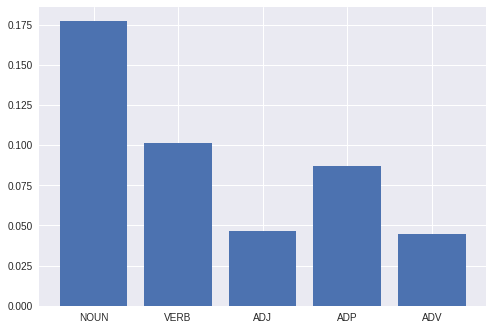

In [ ]:
filter = ['ADJ', 'ADP', 'ADV', 'NOUN', 'VERB']
pos_filtered = {key : value for key, value in pos_total.items() if key in filter}

plt.bar(x = pos_filtered.keys(), height = pos_filtered.values())

On remarque qu'on a un certain équilibre qui semble concorder avec la structure d'une phrase parlée classique en français : légèrement plus de noms que de verbes.

Il pourrait être intéressé de comparer la distribution des mots, la composition moyenne d'une phrase d'une chanson de Booba avec celles en moyenne en langue française. Nous n'avons pas trouvé ces informations, ni eu le temps de récupérer un autre dataset et d'effectuer les mêmes analyses pour comparer.

**Longueur d'une phrase, d'une chanson, et taille totale du corpus**

In [ ]:
def general_analysis (df):

  df_general = df.copy()

  df_general['nb_sentences'] = df_general['lyrics'].apply(lambda x : len(x))
  df_general['words_per_sentence'] = df_general['lyrics'].apply(lambda x : np.sum([len(sentence)/len(x) for sentence in x]))
  df_general['words_per_song'] = df_general['lyrics'].apply(lambda x : np.sum(len(sentence) for sentence in x))

  return df_general


In [ ]:
df_general = general_analysis(df_tok_dropped)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys


<BarContainer object of 254 artists>

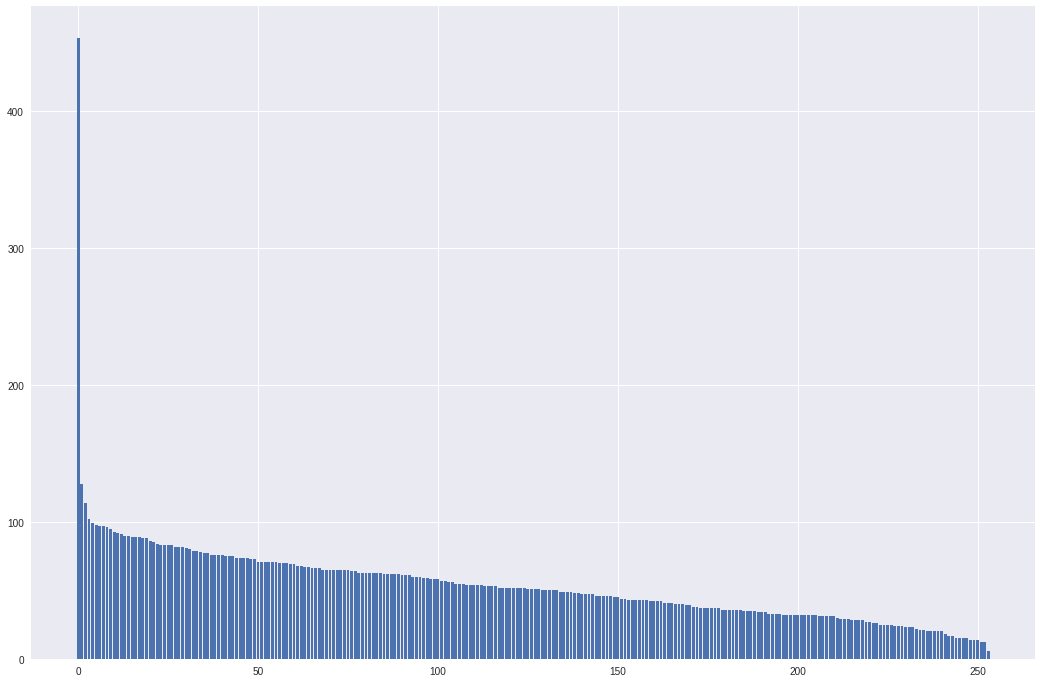

In [ ]:
plt.figure(figsize=(18,12))
plt.bar(x = range(len(df_general)), height = df_general.sort_values(by = 'nb_sentences', ascending = False).nb_sentences)


On a une distribution très cohérente avec celle des mots par chanson qu'on a calculé au dessus. La seule chanson très longue est un freestyle de plusieurs dizaines de minute, et on ne retrouve plus de chansons avec peu de phrases puisqu'on a supprimé les quelques artefacts.

<BarContainer object of 254 artists>

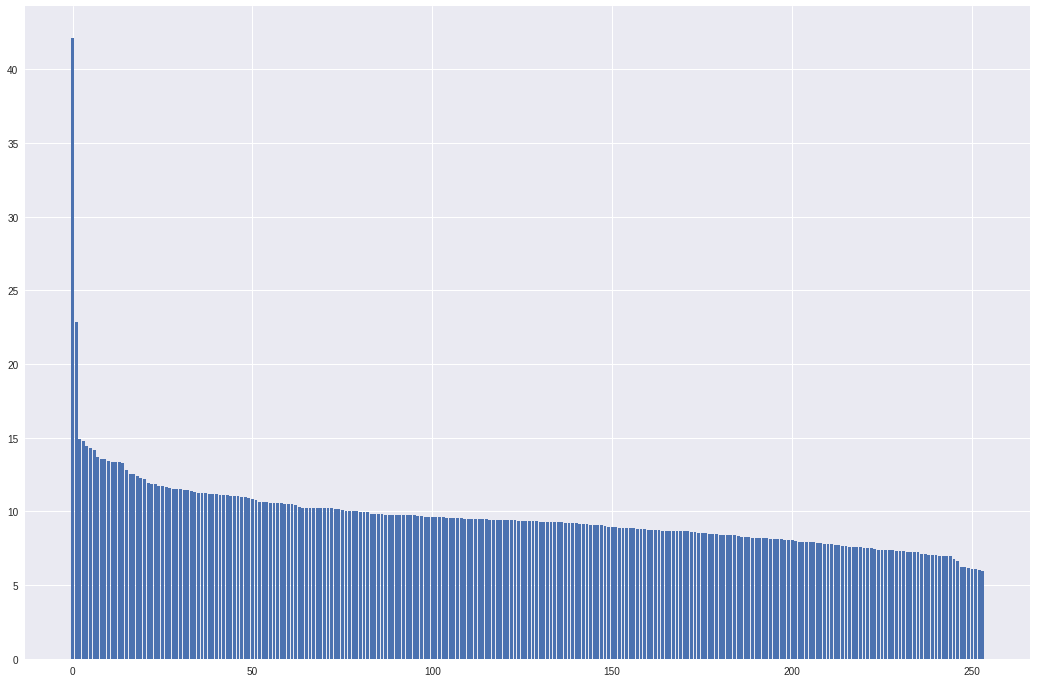

In [ ]:
plt.figure(figsize=(18,12))
plt.bar(x = range(len(df_general)), height = df_general.sort_values(by = 'words_per_sentence', ascending = False).words_per_sentence)

In [ ]:
df_general.sort_values(by = 'words_per_sentence', ascending = False).head(4)

,index,artist_names,album,title,lyrics,nb_sentences,words_per_sentence,words_per_song
200,212,Booba,NaN,Plaza Athénée,"[[J', rêve, d’, un, perso, filtré, mille, fois...",6,42.166667,253
10,10,Booba,ULTRA,5G,"[[Des, migrants, des, Amazones, et, pas, de, J...",21,22.857143,480
85,87,Booba,NaN,Freestyle Pirate,"[[Ne, crois-tu, pas, qu’, je, sais, c’, que, j...",12,14.916667,179
43,43,Booba (Ft. SDM),ULTRA,Bonne journée,"[[Ouais, ouais, ouais], [This, is, a, OG, call...",32,14.812500,474


Les outliers haut ne semblent pas être des anomalies mais simplement des chansons à la structure particulière. On n'observe pas non plus d'outliers bas. 

# IV - Modèles 

## IV - A. Générations de paroles avec un réseau LSTM

Tout d'abord, nous devons construire le vocabulaire associé à nos données.

In [ ]:
cd /content/drive/MyDrive/Projet_NLP

/content/drive/.shortcut-targets-by-id/1AsPxl20DcK0tt2P40UILaQBC1IOTKVGn/Projet_NLP


In [ ]:
import ast

df_tok = pd.read_csv('df_tokenized_dropped.csv')
df_tok.lyrics=df_tok.lyrics.apply(lambda x : ast.literal_eval(x))

In [ ]:
VOC = {'stoi':{},'itos':{},'counts':{},'nbwords':0}

In [ ]:
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

for t in special_symbols: 
  VOC['stoi'][t] = VOC['nbwords']
  VOC['counts'][t] = 1
  VOC['nbwords'] += 1

for song in df_tok.lyrics:
  for line in song:
    for t in line:
      if t not in VOC['stoi']: 
        VOC['stoi'][t] = VOC['nbwords']
        VOC['counts'][t] = 1
        VOC['nbwords'] += 1
      else:
        VOC['counts'][t] = VOC['counts'][t] + 1

In [ ]:
VOC['itos'] = { v:k for k,v in VOC['stoi'].items()}

In [ ]:
VOC['itos'][1]

'<pad>'

In [ ]:
pad_vector=np.zeros(VOC['nbwords'])
pad_vector[1]=1

In [ ]:
sent_list=[]
for song in df_tok.lyrics:
  for line in song:
    res = line.copy()
    res.append('<eos>')
    sent_list.append(res)


In [ ]:
max_len = np.max([len(line) for song in df_tok.lyrics for line in song]) + 1

def prepare_sent(sent):
  prepared_sent=[]
  for tok in sent:
    prepared_sent.append(VOC['stoi'][tok])
  for i in range(len(sent),max_len):
    prepared_sent.append(1) # 1 is pad idx
  return prepared_sent

In [ ]:
from tqdm.notebook import tqdm
sent_list_prepared=[prepare_sent(sent) for sent in tqdm(sent_list)]

  0%|          | 0/13725 [00:00<?, ?it/s]

In [ ]:
import random

random.shuffle(sent_list_prepared)
train_sent_list = sent_list_prepared[:-100]
test_sent_list = sent_list_prepared[-100:]

In [ ]:
len(train_sent_list)

13625

In [ ]:
train_X = train_sent_list
train_y  = []
for sent in train_X:
  sent_trunc = [tok_id for tok_id in sent if tok_id != 1]
  y_sent=[]
  for tok_id in sent_trunc[1:]:
    if tok_id != 3:
      y_sent.append(tok_id)
  while len(y_sent) != max_len:
    y_sent.append(1)
  train_y.append(y_sent)

Nous pouvons maintenant définir notre modèle :

In [ ]:
train_X = np.array(train_X)
train_X = np.expand_dims(train_X,2)

In [ ]:
train_y=np.array(train_y)
train_y=np.expand_dims(train_y,2)

In [ ]:
train_X.shape

(13625, 96, 1)

In [ ]:
import tensorflow as tf

from tf.keras.preprocessing.sequence import pad_sequences
from tf.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tf.keras.preprocessing.text import Tokenizer
from tf.keras.models import Sequential
from tf.keras.optimizers import Adam
import numpy as np 
  
model = Sequential()
model.add(LSTM(700, input_shape=(train_X.shape[1],train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(700, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(700))
model.add(Dropout(0.2))
model.add(Dense(train_y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

In [ ]:
# history = model.fit(train_X,train_y, epochs=300, verbose=1)

Nous n'avons pas réussi à débugger notre code, cependant ce modèle devait servir de baseline. Par contrainte de temps, nous avons ainsi décidé de nous focaliser sur notre modèle principal (voir ci-dessous).

## IV - B. GPT-2

#### Tokenisation (afin d'utiliser les embeddings préentraînés de GPT2) 

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2",bos_token = '<|bos|>',eos_token = '<|pad|>', pad_token ='<|pad|>')

Downloading:   0%|          | 0.00/951k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/519k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
tokenizer.pad_token_id

50258

In [ ]:
from tqdm.notebook import tqdm
sent_list=[]
for lyrics in tqdm(df.lyrics):
  doc=nlp(lyrics)
  for sent in doc.sents:
    sent = " ".join([tok.text.strip('-') for tok in sent if not tok.is_punct]) #peut-être mettre tout en .lower ?
    sent_list.append('<|bos|>'+sent + '<|pad|>')

sent_list[:10]

  0%|          | 0/274 [00:00<?, ?it/s]

["<|bos|>9 décembre j' ai les mains froides<|pad|>",
 "<|bos|>La France veut m' embaucher tenter d' me réchauffer<|pad|>",
 '<|bos|>Elle peut se mettre un oid je ferai mon propre chemin<|pad|>',
 "<|bos|>Non à l' A.N.P.E oui à la débauche fuck<|pad|>",
 '<|bos|>demain<|pad|>',
 '<|bos|>Citations sans félicitations de drame en drame<|pad|>',
 "<|bos|>Je n' fais pas bonne impression je sais<|pad|>",
 "<|bos|>J' avance de gramme en gramme<|pad|>",
 "<|bos|>Mais j' ai choisi ce train d' vie j' en assumerai les conséquences<|pad|>",
 "<|bos|>Des aléas d' la street j' en ai pris connaissance<|pad|>"]

In [ ]:
sent_list_tok_len=[len(tokenizer.tokenize(sent)) for sent in sent_list]
np.max(sent_list_tok_len)

135

In [ ]:
np.quantile(sent_list_tok_len,0.99) #we can set max_len=40 for truncation

38.0

In [ ]:
max_length = 40

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, max_length=40):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer(txt, truncation=True, max_length=max_length, padding="max_length") #tokenize with pretrained tokenizer

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
dataset = GPT2Dataset(sent_list, tokenizer)

# Split into training and validation sets
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

13,140 training samples
  692 validation samples


In [ ]:
batch_size = 8

# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# V - Utilisation

## V - A. LSTM

## V - B. GPT-2

### 1er entraînement

In [ ]:
# Load pretrained model
model = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2")

model.resize_token_embeddings(len(tokenizer)) #because we added bos and pad tokens

# use colab GPU
device = torch.device("cuda")
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [ ]:
# Hyperparamètres

epochs = 5
learning_rate = 1e-4
warmup_steps = 1e2
epsilon = 1e-8

sample_every = 100

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
total_steps = len(train_dataloader) * epochs

# lr scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=50257,#random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()


    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluation
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Enregistrement des statistiques de l'époque
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Durée d'entraînement{:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,643. Loss: 1.2494338750839233.   Elapsed: 0:00:09.
0: ée


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,643. Loss: 1.1746877431869507.   Elapsed: 0:00:21.
0: là quand je n' ai pas que ça à foutre dans la vie


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,643. Loss: 2.451486349105835.   Elapsed: 0:00:33.
0: ée pour un rien n' est vrai j' en suis sûr


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,643. Loss: 1.3036432266235352.   Elapsed: 0:00:45.
0: Route-taille-caille-caille-caille-caille-caille


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,643. Loss: 1.0454399585723877.   Elapsed: 0:00:57.
0: J' y vais pour changer des vies


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,643. Loss: 1.573357343673706.   Elapsed: 0:01:10.
0: J' ai l' habitude d' appeler ça de la " pate ze-nienne m' a dit comment t' en rendre compte


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,643. Loss: 1.872916579246521.   Elapsed: 0:01:23.
0: Oublié


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,643. Loss: 1.1064521074295044.   Elapsed: 0:01:34.
0: J' ai la haine qu' au fond de ta gorge


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,643. Loss: 1.6446621417999268.   Elapsed: 0:01:46.
0: T' auras vu mon cul à la télé t' as vu


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,643. Loss: 1.548025369644165.   Elapsed: 0:01:58.
0: Moi et mon rap de merde


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,643. Loss: 1.503975749015808.   Elapsed: 0:02:10.
0: Elle veut que des gros bras elle sait ce qu' elle est jolie


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,643. Loss: 1.6613613367080688.   Elapsed: 0:02:22.
0: Laquelle de nos victimes est la tienne


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,643. Loss: 1.545487642288208.   Elapsed: 0:02:34.
0: Je suis riche tristement célèbre riche tristement célèbre


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,643. Loss: 0.8258863687515259.   Elapsed: 0:02:45.
0: La belle vie n' est pas une légende comme à Miami


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,643. Loss: 1.0103126764297485.   Elapsed: 0:02:57.
0: J' vais l' arrêter


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,643. Loss: 1.1217824220657349.   Elapsed: 0:03:09.
0: Tu m’ fais la misère mais j’ ai la haine négro

  Average training loss: 1.42
  Training epoch took: 0:03:16

Running Validation...
  Validation Loss: 1.23
  Validation took: 0:00:02

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,643. Loss: 0.6972397565841675.   Elapsed: 0:00:09.
0: À cause de leurs fesses leur tête est mise à l' amende


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,643. Loss: 0.7789488434791565.   Elapsed: 0:00:21.
0: Tu veux un fion


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,643. Loss: 0.843469500541687.   Elapsed: 0:00:32.
0: .There’ s' rait bien de s' faire niquer mais faut pas se faire d' harissa


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,643. Loss: 1.1167594194412231.   Elapsed: 0:00:44.
0: La rue m' fait rire la rue m' fait pleurer


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,643. Loss: 0.8657284379005432.   Elapsed: 0:00:56.
0: Toujours sur mes rimes pleines de haine c' est du béton armé j' suis calibré


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,643. Loss: 1.077143669128418.   Elapsed: 0:01:08.
0: J’ ai fait sauter l’op avec du crack


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,643. Loss: 0.8548265099525452.   Elapsed: 0:01:19.
0: Mais j' suis aussi un mec tah et tu n' as pas d' oseille


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,643. Loss: 0.8445454835891724.   Elapsed: 0:01:31.
0: C' est la Ouest Ouest Ouest


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,643. Loss: 0.7357938885688782.   Elapsed: 0:01:43.
0: Je ne sais que fuir n’ me quitte plus


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,643. Loss: 1.3608635663986206.   Elapsed: 0:01:55.
0: Dou-double


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,643. Loss: 1.2034412622451782.   Elapsed: 0:02:07.
0: Ma life est incroyable


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,643. Loss: 1.0590131282806396.   Elapsed: 0:02:18.
0: Je n' vais pas aux funérailles comme l' agent Carter


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,643. Loss: 0.8897281289100647.   Elapsed: 0:02:30.
0: J’ ai une kalash et une flûte et un shab Obi-Wan Kenobi à chaque épaule


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,643. Loss: 0.8252580165863037.   Elapsed: 0:02:42.
0: Tu veux savoir qui j' suis est


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,643. Loss: 1.1971580982208252.   Elapsed: 0:02:54.
0: J' ai quitté la réalité pour de vrai


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,643. Loss: 1.143969178199768.   Elapsed: 0:03:05.
0: Tu veux détrôner le Duc

  Average training loss: 0.99
  Training epoch took: 0:03:12

Running Validation...
  Validation Loss: 1.16
  Validation took: 0:00:02

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,643. Loss: 0.5357323288917542.   Elapsed: 0:00:09.
0: Dou-double


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,643. Loss: 0.45579901337623596.   Elapsed: 0:00:21.
0: Ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,643. Loss: 0.6514036059379578.   Elapsed: 0:00:32.
0: On contrôle la zone on contrôle la zone


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,643. Loss: 0.5706748962402344.   Elapsed: 0:00:44.
0: J' suis àl à l' antenne hertzienne


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,643. Loss: 0.9419530034065247.   Elapsed: 0:00:56.
0: Les plus sages me disent de me ranger


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,643. Loss: 0.7374453544616699.   Elapsed: 0:01:08.
0: Tu veux pas goûter nos bastos kho j' te préviens.9.2.Ouais gros c' est du son lourd ça pèse de lourdes peines


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,643. Loss: 0.858559250831604.   Elapsed: 0:01:20.
0: Yeah yeah


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,643. Loss: 0.521914005279541.   Elapsed: 0:01:31.
0: Juste au micro je t' fais la misère


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,643. Loss: 0.6524341106414795.   Elapsed: 0:01:43.
0: Plein d' vices je n' ai pas d' âme oh


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,643. Loss: 1.0119391679763794.   Elapsed: 0:01:55.
0: Bakel City Gang Saddam Hauts-de-Seine


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,643. Loss: 0.8278493881225586.   Elapsed: 0:02:07.
0: Si tu parles mal tu vas t' la faire descendre vas t' faire descendre


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,643. Loss: 0.9260635375976562.   Elapsed: 0:02:18.
0: Rester vraie sa qualité


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,643. Loss: 1.079698920249939.   Elapsed: 0:02:30.
0: J' me frappe le torse mais j' peux faire des passes


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,643. Loss: 0.9583064317703247.   Elapsed: 0:02:42.
0: Enculé je serai rapatrié enterré au Sénégal


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,643. Loss: 0.8193013668060303.   Elapsed: 0:02:54.
0: C’ est pas qu’ j’ aime pas me mélanger mais disons


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,643. Loss: 0.7175292372703552.   Elapsed: 0:03:06.
0: Donne moi la main gentiment offerte par ma biatch

  Average training loss: 0.74
  Training epoch took: 0:03:12

Running Validation...
  Validation Loss: 1.18
  Validation took: 0:00:02

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,643. Loss: 0.4220831096172333.   Elapsed: 0:00:09.
0: Si je suis en retard au dépôt ou en cour martiale c' est qu' ils n' m' ont pas à la SNEP


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,643. Loss: 0.579767107963562.   Elapsed: 0:00:20.
0: Devinez ce que les hommes ont à faire


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,643. Loss: 0.3598170578479767.   Elapsed: 0:00:32.
0: Rester fidèle au bitume


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,643. Loss: 0.4533936083316803.   Elapsed: 0:00:44.
0: J' suis au charbon j' suis au charbon


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,643. Loss: 0.4099459648132324.   Elapsed: 0:00:56.
0: Planté dans les années 30 les semelles de Louboutin viennent d' Italie


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,643. Loss: 0.8167559504508972.   Elapsed: 0:01:08.
0: Mon pays va mal va mal


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,643. Loss: 0.518497884273529.   Elapsed: 0:01:19.
0: Partir au charbon fuck les clim et leurs gros condés.700 chevaux sur l' bateau


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,643. Loss: 0.6156306862831116.   Elapsed: 0:01:31.
0: On sort le 47 AK.Je fais le nécessaire dans l' illicite peut on dire qu' on est lésé


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,643. Loss: 0.48004668951034546.   Elapsed: 0:01:43.
0: Si je me mets à chanter c' est pour Dieu


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,643. Loss: 0.39103806018829346.   Elapsed: 0:01:55.
0: On a fumé des ne-jau ils nous ont fumé nos vieux


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,643. Loss: 0.5271819233894348.   Elapsed: 0:02:07.
0: J' suis dans l' espace j' mets que du Nike Air


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,643. Loss: 0.7236520051956177.   Elapsed: 0:02:18.
0: Dix piges mon shit 600 chevaux minimum


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,643. Loss: 0.545785129070282.   Elapsed: 0:02:30.
0: Parti de zéro sans toucher ni crack ni héroïne


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,643. Loss: 0.3945765793323517.   Elapsed: 0:02:42.
0: Le monde appartient à ceux qui se lévent tôt


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,643. Loss: 0.3700856864452362.   Elapsed: 0:02:54.
0: Hôtel des Vosges


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,643. Loss: 0.49555084109306335.   Elapsed: 0:03:06.
0: Je veux du challenge j' ai la carte des vins

  Average training loss: 0.54
  Training epoch took: 0:03:12

Running Validation...
  Validation Loss: 1.21
  Validation took: 0:00:02

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,643. Loss: 0.5152727961540222.   Elapsed: 0:00:09.
0: Mon premier spliff ma première bouteille


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,643. Loss: 0.5016300678253174.   Elapsed: 0:00:20.
0: J' arrête des carrières pour de vrai


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,643. Loss: 0.4081122875213623.   Elapsed: 0:00:32.
0: Mon prof m' a dit arrête pourtant c' est vrai tu n' as pas fait la classe comme si t' allais sauter


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,643. Loss: 0.3606947958469391.   Elapsed: 0:00:44.
0: J’ peux reprendre ton flow c’ est pas la fin


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,643. Loss: 0.3119238317012787.   Elapsed: 0:00:56.
0: Dans le futur j’ suis à Key Largo niquer des mères


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,643. Loss: 0.4191489517688751.   Elapsed: 0:01:08.
0: Toujours de la route avant d’ arriver j' ai fait du hazalaza pour que la kichta tienne les nanasses


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,643. Loss: 0.45159149169921875.   Elapsed: 0:01:19.
0: Je n' ai que de l' amour pour une fille alors j' fais l' amour avec un mec


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,643. Loss: 0.4416468143463135.   Elapsed: 0:01:31.
0: J' ai d' la pure de Bogota j' monte sur Gotham Gotham City


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,643. Loss: 0.4619447886943817.   Elapsed: 0:01:43.
0: Je sais qu' ils ne m' entendront pas crier car je suis leurre-mè


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,643. Loss: 0.45075899362564087.   Elapsed: 0:01:55.
0: Pas de flashes pour nos clichés nous on s' lève juste pour pisser


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,643. Loss: 0.41344672441482544.   Elapsed: 0:02:07.
0: En fait c' que tu nous caches est que tu n' l' aimes pas


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,643. Loss: 0.3696981370449066.   Elapsed: 0:02:18.
0: J' en ai gros dans les soupapes je ne pourrai donc pas passer les vitesses.125 centimètres cube d' sang dans les poumons


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,643. Loss: 0.4897623658180237.   Elapsed: 0:02:30.
0: Les plus sages me disent de me ranger


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,643. Loss: 0.39295339584350586.   Elapsed: 0:02:42.
0: Fais tourner l' disque fais tourner l' shit vite fais tourner l' shit vite fait


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,643. Loss: 0.4113084375858307.   Elapsed: 0:02:54.
0: Dans le game j' ai crocs de félins.36 Chambers Wu-Tang-Clan


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,643. Loss: 0.34250608086586.   Elapsed: 0:03:06.
0: Si t' es offensée baby on s' excuse bah oui

  Average training loss: 0.42
  Training epoch took: 0:03:12

Running Validation...
  Validation Loss: 1.24
  Validation took: 0:00:02

Training complete!
Total training took 0:16:14 (h:mm:ss)


In [ ]:
print("Saving model to %s" % wdir)
model_to_save = model.module if hasattr(model, 'module') else model  # in case of distributed/parallel training
model_to_save.save_pretrained(wdir+'/mymodel.bin')
tokenizer.save_pretrained(wdir+'/firstmodel')

### 1ère Evaluation

Dans ce qui suit, nous générons des paroles dans le style de Booba, en jouant sur la "temperature du modèle", ce qui permet de fournir des paroles plus ou moins proche des paroles originales (si on augmente trop la température, les paroles perdent du sens, si elle est trop faible elles correspondent exactement à des paroles écrites par Booba).

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(bos_token_id=50257,
                                do_sample=True,   
                                #top_k=5, 
                                #max_length = 300,
                                #top_p=0.95, 
                                num_return_sequences=30,
                                temperature = 1.8,
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[   30,    94,   899,  2767, 11883, 13515,    86,    94,    32]],
       device='cuda:0')
0: Fais la route n' rôme pas en pleine chatte à Germede.14 années


1: Bag bang en mode Sur écoute personne n' insiste


2: Pas de petite garce juste quelques mamans qui aiment bien un seul homme


3: Chacune pratique le rap à son art.Un bif à JLo ces sapes pend


4: Je les prendrai je rentre d' mon street-show avec mes baskets


5: L' amourla première classe c' est dans l' béton La hernie cardraine


6: Pour tous les gangsters enfermés pour tous les criminels libres


7: Châtelet.•


8: J' suis prêt suce la queue bien profond


9: Vrai


10: Nigga!.Arôme miel et citron acide mes rimes ne meurent jamais Dwayne


11: Du Pont d' Sèvres ligne 9.Miraday me dis pas


12: .Coup de jambes pépère viens m' voir chez le védi?.Salopes


13: Mon équipe fait du jeu dangereux du mitard sais-tu jouer


14: Noire est ma ceinture bitume argent vaut ce océan d' ennemis


15: Du blues d' Haïti des lyrics US.

In [ ]:
model.eval()

prompt = "Je ne fais que"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(generated,
                                #bos_token_id=50257,
                                do_sample=True,   
                                #top_k=5, 
                                #max_length = 300,
                                #top_p=0.95, 
                                num_return_sequences=10,
                                temperature = 1.5,
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[4274,  423, 1383,  354]], device='cuda:0')
0: Je ne fais que nous franchis pas nos sites


1: Je ne fais que déguster


2: Je ne fais que me prêter de l' amour que je n' aurais jamais dû


3: Je ne fais que déguster


4: Je ne fais que raconter de la merde si vous le voulez bien entendu


5: Je ne fais que représenter


6: Je ne fais que rentrer en matière c' est très dur


7: Je ne fais que featuring sur des rimes enculé ma dose


8: Je ne fais que vendre de la substances


9: Je ne fais que me prêter de l' amour que je n' rends pas




In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2",bos_token = '<|bos|>',eos_token = '<|pad|>', pad_token ='<|pad|>')

Downloading:   0%|          | 0.00/951k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/519k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Load pretrained model
model = GPT2LMHeadModel.from_pretrained('./firstmodel/first_model.bin',config='./firstmodel/config.json')

model.resize_token_embeddings(len(tokenizer)) #because we added bos and pad tokens

# use colab GPU
device = torch.device("cuda")
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

#### Generating with high temperature (less overfitting)

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(bos_token_id=50257,
                                do_sample=True,   
                                #top_k=5, 
                                #max_length = 300,
                                #top_p=0.95, 
                                num_return_sequences=30,
                                temperature = 1.8,
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[   30,    94,   899,  2767, 11883, 13515,    86,    94,    32]],
       device='cuda:0')
0: À voir cette bande de fils de putain fumer ces chichis


1: Les mains sales j' ai eu l' AR j' avais les lacets coincés


2: Ma life elle rajeunit mes lyrics une seule parole une seule idée


3: La première cèdera reste fraîche y aura pas tain' zez la deuxième pute à eu


4: Mon dernier hit single Desert Eagle


5: Génération hasch nouvelle époque paire de Maradonna


6: Si tu ne veux pas goûter ferme ta gueule va ouvrir tes seufs hé


7: Nan Izi Berretta la Ferrari


8: J' leur mets des doigts zebi comme à James Harden


9: J' suis un fumier j’ fais le biff quand on m' aqué


10: Tu prends tes cliques tu niques ta mère oui


11: N’ ayez crainte si mes khos font de la hass des métiers pourris


12: Tire joue mon son arrache le ton si tu n' es pas convaincu


13: Bakel City Gang Saddam


14: Les keufs n' étaient pas chez toi donc on peut toujours klaxonner


15: Il me faudra encore d’ l’ 

#### Generating with low temperature (more overfitting)

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(bos_token_id=50257,
                                do_sample=True,   
                                #top_k=5, 
                                #max_length = 300,
                                #top_p=0.95, 
                                num_return_sequences=15,
                                temperature = 1.8,
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[   30,    94,   899,  2767, 11883, 13515,    86,    94,    32]],
       device='cuda:0')
0: Du ghetto de Sarajevo lajan frape de Babooyene manman


1: Pilon de zbeh quand on marche vite les khois nous enferment


2: Kay mod zot vini vwè nou


3: Pour un joint ils en appellent 3 pour moi ça parle déjà)9Embed


4: Banlieue Ouest des États-Unis fe


5: Je perd 92 kilos en volant quest ce que j’ devenir


6: Pas d' zéro neuf sans ski alpin mon vin et son biffet'


7: Cause


8: Train d' vie d' traficante


9: T' as saisi on est sur la liste j' me jettes sur toi dans mes rues


10: If you think anybody I think I can be a killer


11: Ils veulent m' arracher goût de vivre se retournent donc en pédalière


12: Et si un jour je dois plier c’ est devant un flic africain hein oh Vladimir


13: N' essaie pas d' mettre des doigts par un cigare


14: Mon rap t' attrape par l' col nouvelle école




### Résultats de l'évaluation par 50 élèves de l'ENSAE / amis

In [4]:
booba = [75.5,73.6,73.5,74.1,48.2,83.1,85.7,42.9]
boobot_1 = [22.6,62.3,34,35.8,41.5,68,64.2,39.6,74.1,25.5,51.8,55.4,32.1,35.7,57.1,75,42.9,80.4,75,80,26.8,50,83.9,69.6]

boobot_18 = [51,42,37.7]

In [7]:
print(np.mean(booba),100-np.mean(booba))

69.57499999999999 30.42500000000001


In [8]:
print(np.mean(boobot_1),100-np.mean(boobot_1))

53.47083333333333 46.52916666666667


In [9]:
print(np.mean(boobot_18),100-np.mean(boobot_18))

43.56666666666666 56.43333333333334
